In [1]:
import sqlite3 as sql
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np

from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

warnings.filterwarnings("ignore")

In [2]:
def wrangle(db_path):
    db = "earth_quake_damage.db"
    con = sql.connect(db_path)
    
    query = '''SELECT * FROM NepalEarhquakeDamage2015  WHERE district_id == 24'''
    
    df = pd.read_sql_query(query, con)
    
    df["b_id"] = np.ceil(df["building_id"] / 1e6)
    df = df.set_index("b_id")
    
    df.drop(columns=["building_id", "district_id"], inplace=True)
    
    df.drop(columns=["count_floors_post_eq", "height_ft_post_eq", "condition_post_eq"], inplace=True)
    
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"]>3).astype(int)
    
    df.drop(columns=["damage_grade"], inplace=True)
    
    df.drop(columns=["count_floors_pre_eq"], inplace=True)
    
    return df

In [3]:
df = wrangle("earth_quake_damage.db")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 98019 entries, 240102.0 to 249010.0
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            98019 non-null  int64 
 1   plinth_area_sq_ft       98019 non-null  int64 
 2   height_ft_pre_eq        98019 non-null  int64 
 3   land_surface_condition  98019 non-null  object
 4   foundation_type         98019 non-null  object
 5   roof_type               98019 non-null  object
 6   ground_floor_type       98019 non-null  object
 7   other_floor_type        98019 non-null  object
 8   position                98019 non-null  object
 9   plan_configuration      98019 non-null  object
 10  severe_damage           98019 non-null  int32 
dtypes: int32(1), int64(3), object(7)
memory usage: 8.6+ MB
None


,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,severe_damage
b_id,,,,,,,,,,,
240102.0,40,324,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0
240102.0,30,382,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,1
240102.0,13,405,10,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,1
240102.0,25,328,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,Rectangular,1
240102.0,15,405,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1


In [4]:
target = "severe_damage"

y= df[target]
X = df.drop(columns=[target])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [7]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("accuracy baseline:", acc_baseline)

accuracy baseline: 0.5400274182235542


In [8]:
model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=9, random_state=42)
).fit(X_train, y_train)
model

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'data_type': dtype('O'...
                                          'mapping': Not attached       1
Attached-1 side    2
Attached-2 side    3
Attached-3 side    4
NaN               -2
dtype: int64},
                                         {'col': 'plan_configuration',
         

In [9]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = accuracy_score(y_val, model.predict(X_val))
print("acc train:", acc_train.round(2))
print("acc val:", acc_val.round(2))

acc train: 0.68
acc val: 0.66


In [10]:
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
tree_depth

9

In [11]:
depth_hyperparams = range(1, 50, 2)

In [12]:
train_acc = []
val_acc = []

for d in depth_hyperparams:
    test_model = model = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth = d, random_state=42)
    )
    test_model.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, test_model.predict(X_train)))
    val_acc.append(test_model.score(X_val, y_val))
    
print("training accuracy score:", train_acc[:5])
print("validation accuracy score:", val_acc[:5])

training accuracy score: [0.6367723012178792, 0.6454122298029714, 0.6546897914939743, 0.6659918382962443, 0.6778518140661863]
validation accuracy score: [0.636230313077855, 0.6447745966970605, 0.6521711407256264, 0.6579098386788242, 0.6615443473825161]


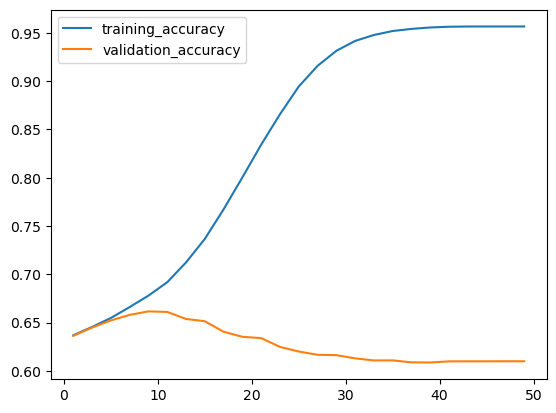

In [13]:
plt.plot(depth_hyperparams, train_acc, label="training_accuracy")
plt.plot(depth_hyperparams, val_acc, label="validation_accuracy")
plt.legend();

In [14]:
test_acc = accuracy_score(y_test, model.predict(X_test))
print("test accuracy:", test_acc.round(2))

test accuracy: 0.61


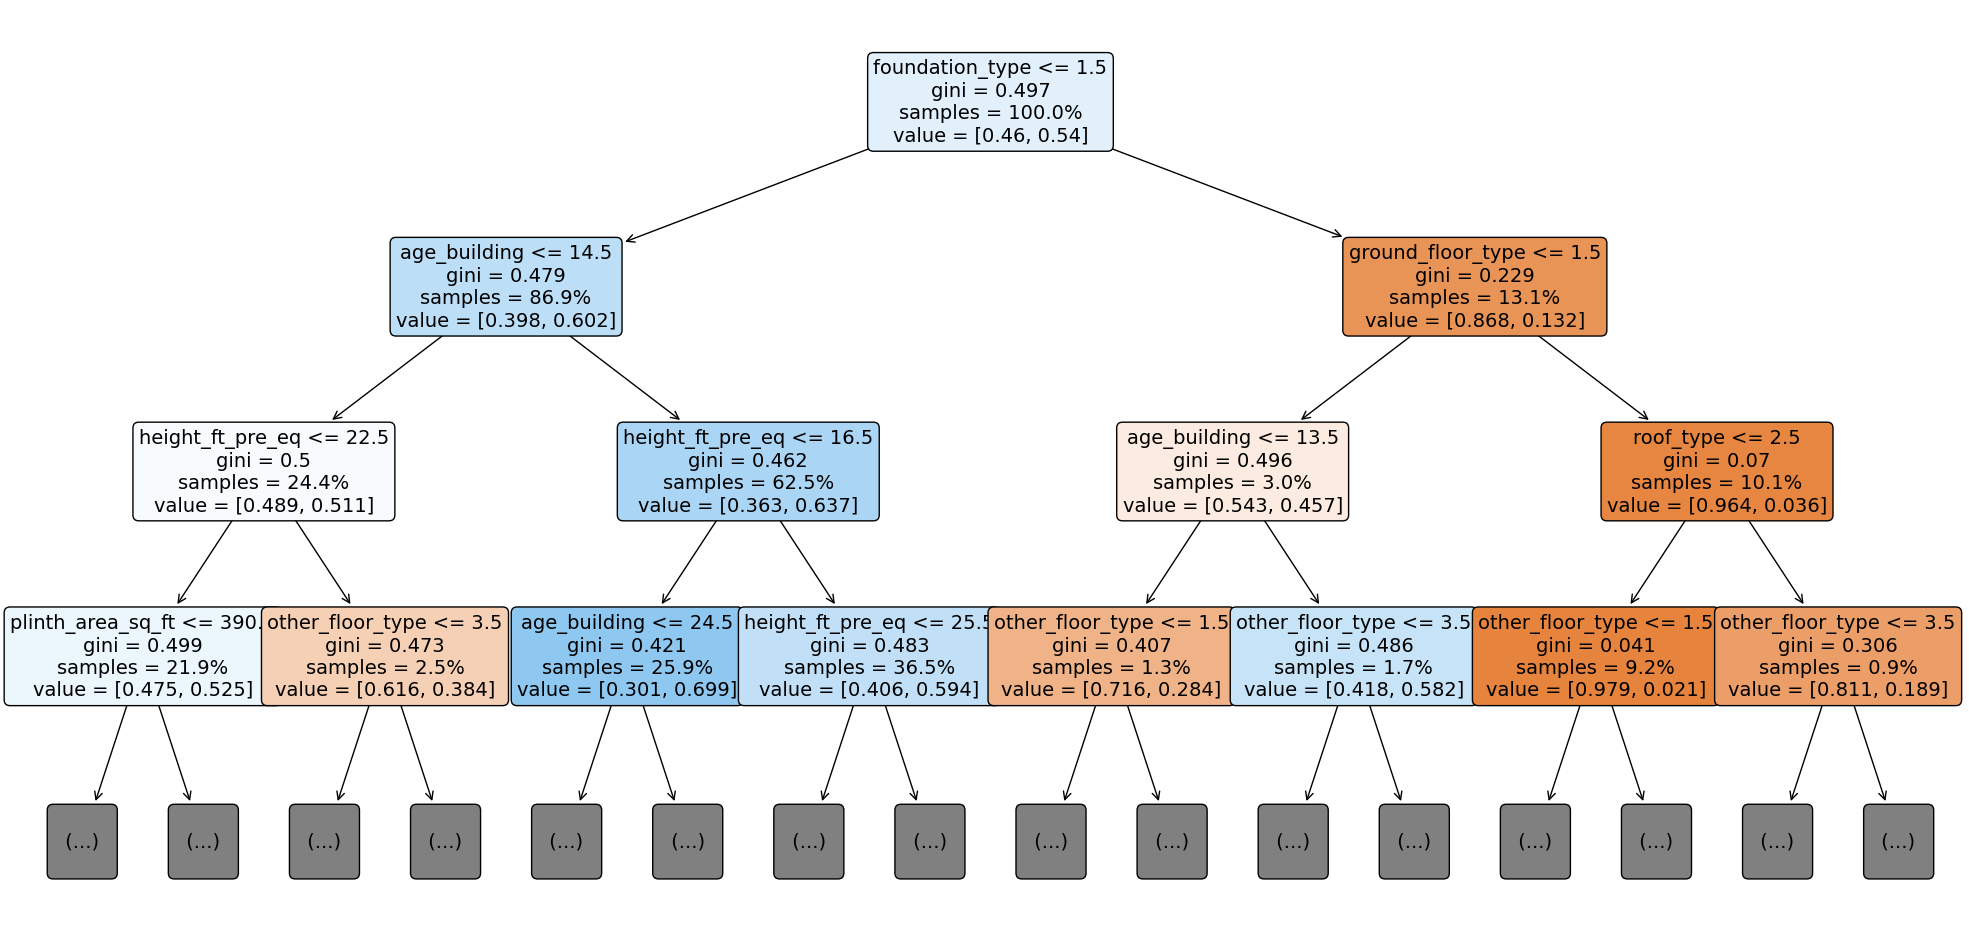

In [15]:
fig, ax = plt.subplots(figsize=(25, 12))
plot_tree(
    decision_tree = model.named_steps["decisiontreeclassifier"],
    feature_names = X_train.columns,
    filled = True,
    rounded = True,
    proportion = True,
    max_depth = 3,
    fontsize = 14,
    ax=ax
);

In [16]:
feature_names = X_train.columns
importances =  model.named_steps["decisiontreeclassifier"].feature_importances_

print("feature:", feature_names[:3])
print("importance:", importances[:3])

feature: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
importance: [0.23792923 0.34752519 0.1301184 ]


In [17]:
df_test = pd.Series(importances, index=feature_names).sort_values()
df_test.tail()

position             0.046457
foundation_type      0.114408
height_ft_pre_eq     0.130118
age_building         0.237929
plinth_area_sq_ft    0.347525
dtype: float64

In [18]:
df_test.sum()

1.0

<AxesSubplot:>

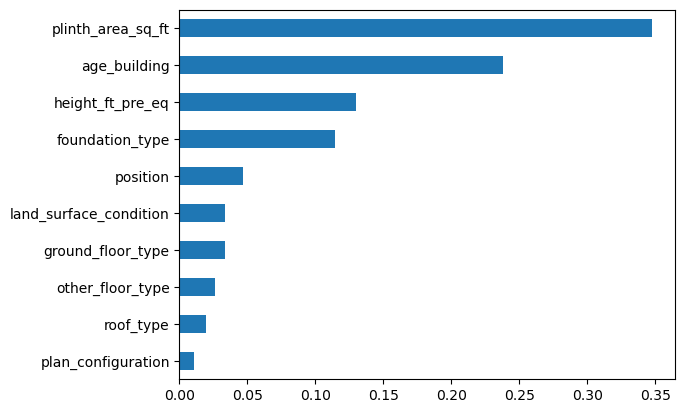

In [19]:
df_test.plot(kind="barh")